# GTI771 - Apprentissage machine avancé
## Département de génie logiciel et des technologies de l’information



## Laboratoire 7 - Réseaux de neurones convolutifs (CNN) - classification et régression
#### <font color=black> Version 2 - Été 2024 </font>

##### <font color=grey> Version 1 - Prof. Alessandro L. Koerich.
##### Version 2 - Chargé de lab. Arthur Josi

| NOMS                  | CODE PERMANENT  |  PARTICIPATION     |
|-----------------------|-----------------|--------------------|
| Hugo Rhéaume-Simard   | RHEH93080004          |    33%            |
| Laurent Marleau-Gallant             |  MARL05109800  |      33%            |
| Yulia Bakaleinik             | BAKY30539705        |     33%            |

## Introduction
Ce laboratoire porte sur l'apprentissage de la représentation (primitives) et du discriminant d'une façon intégrée avec des réseaux neuronaux convolutifs

Vous devez proposer des architectures CNN aﬁn de résoudre deux problèmes: prédiction de l'âge de personnes à partir de photos du visage (régression - dataset FG-NET); prédiction des émotions à partir de photos du visage (classification - dataset FER), introduits dans le cadre des laboratoires précédents.

L’évaluation de ce laboratoire sera basée sur:
- la qualité des réseaux de neurones proposés et utilisés; (10%)
- utilisation du protocole et mesures de performance appropriées; (10%)
- les réponses aux questions dans ce notebook;(70%)
- l'organisation de votre code source (SVP, n'oubliez pas de mettre des commentaires dans le code source!); (10%)

# Modules et bibliotèques python

### Import de bibliotèques

###  <font color=blue> À faire: </font>
1. Ajouter les bibliothèques que vous avez utilisées pour compléter ce notebook dans une cellule avec une petite description.

In [2]:
import numpy as np  # package for scientific computing with Python.
import matplotlib.pyplot as plt # 2D plotting library
import pandas as pd
import os
import re
from PIL import Image
import numpy as np
import re 
import face_recognition
import cv2
from mtcnn import MTCNN

import torchvision
print(torchvision.__version__)
print(dir(torchvision))

from skimage import io, exposure, filters, transform, color
from skimage.color import rgb2gray

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, top_k_accuracy_score

0.19.0+cpu
['Module', '_HAS_OPS', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_image_backend', '_internally_replaced_utils', '_is_tracing', '_meta_registrations', '_utils', '_video_backend', 'datasets', 'disable_beta_transforms_warning', 'extension', 'get_image_backend', 'get_video_backend', 'io', 'models', 'ops', 'os', 'set_image_backend', 'set_video_backend', 'torch', 'transforms', 'utils', 'version', 'warnings']


### Définition des fonctions

In [3]:
def fa():
    return 1

# Partie 1 - Apprentissage de représentation et régression avec FG-NET (40%)

Point de départ: fichier *fg-net-nxm.csv* - images nettoyées et normalisées avec résolution $n$ $\times$ $m$.

## 1a: Données de FG-NET. (10%)

###  <font color=blue> À faire: </font>
1. Reprenez vos images FG-NET savaugardées dans un fichier *csv*. Vous devez lire ces images et les représenter sous la forme d’une matrice $X\_data$ aussi que les vecteurs $Y\_data$ avec les âges (étiquettes) et $Z\_data$ avec les id des sujets.

In [4]:
data = np.loadtxt('fg-net-128x104.csv.csv', delimiter=',',dtype=str)
#data = np.loadtxt('content/fg-net-4x4-restNET50v2.csv', delimiter=',',dtype=str)
#data = np.loadtxt('content/fg-net-nxm.csv.csv', delimiter=',',dtype=str)


def transform_str_float(d):
    return np.array([np.fromstring(row, sep=' ', dtype=float) for row in d])

x_data = transform_str_float(data[1:,2])
y_data = np.array(data[1:,1], dtype=int)
z_data = np.array(data[1:,0], dtype=int)

print(f"fg-net:\t{x_data.shape[1]} features")



pca = PCA(n_components=1000)
x_data_pca = pca.fit_transform(x_data)

print(f"pca:\t{x_data_pca.shape[1]} features")

print(f"fg-net:\t{x_data_pca.shape[0]} samples")



X_data = x_data

##Print shape of X_data
print(X_data.shape)
X_data = np.reshape(X_data, (X_data.shape[0],128, 104,3))
print(X_data.shape) 

##Print shape of y_data
print(y_data.shape)

##Print shape of z_data
print(z_data.shape)


fg-net:	39936 features
pca:	1000 features
fg-net:	1000 samples
(1000, 39936)
(1000, 128, 104, 3)
(1000,)
(1000,)


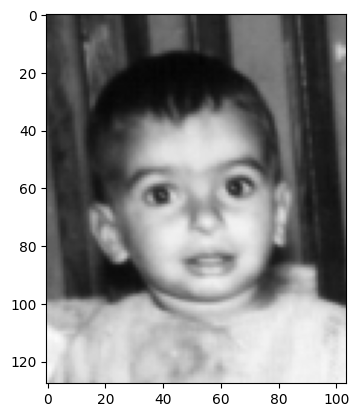

In [5]:

#Testing to see if the images appear well
image = X_data[0]
plt.imshow(image)
plt.show()



  2.  **Explications:**

Définition du protocole expérimental avec FG-NET.

Idéalement, vous devez utiliser le protocole <font color=blue> "Leave One Subject Out Cross-Validation" </font> (LOSO).

Cependant, en raison des longs temps d'apprentissage des CNNs, un tel protocole expérimental n'est pas réalisable. Par conséquent, vous êtes invité à établir un protocole "hold-out" pour l'ensemble de données FG-NET.

Je vous suggère une répartition 50% - 20% - 30% entraînement-validation-test. Cependant, vous devez faire cette répartition "par sujet" pour vous assurer que les visages d'un même sujet ne sont présents que sur une seule partition.

Par exemple, en supposant 10 sujets avec 20 visages chacun. Vous aurez un ensemble d’entraînement avec 5 sujets (sujets A, B, C, D, E - 100 images de visage), un ensemble de validation avec 2 sujets (sujets F, G - 40 images de visage) et un ensemble de tests avec 3 sujets (sujets H, I, J - 60 images de visage).

  **A faire:** Créer trois partitions de données à partir des images de FG-NET:
    - Ensemble d'entraînement - *D_train* (50% x 82) = 41 sujets
    - Ensemble de validation - *D_valid* (20% x 82) = 17 sujets
    - Ensemble de tests - *D_test* (30% x 82) = 24 sujets <br><br>
    
    Ici, vous devez aussi faire attention pour ne changer pas la distribution d'âges dans les partitions de données (stratified sampling).

In [6]:


#Seprating the data into training and testing data

#Each ID has a number of image, a distribution and a mean age

#We need to separate these samples without disturbing the distribution of the data

id_ages = {}
for id in np.unique(z_data):
    id_ages[id] = y_data[z_data == id].tolist()

print(id_ages)



{1: [2, 5, 8, 10, 14, 16, 18, 19, 22, 28, 29, 33, 40, 43, 43], 2: [3, 4, 5, 7, 12, 15, 16, 18, 20, 21, 23, 26, 29, 31, 36, 38], 3: [18, 20, 23, 25, 35, 38, 47, 49, 51, 58, 60, 61], 4: [19, 21, 26, 28, 30, 37, 40, 48, 51, 53, 62, 63], 5: [18, 24, 30, 31, 35, 40, 45, 48, 49, 52, 61], 6: [24, 28, 31, 36, 40, 42, 46, 51, 55, 61, 67, 69], 7: [1, 18, 22, 23, 26, 37, 38, 39, 45], 8: [3, 6, 8, 12, 13, 16, 17, 18, 21, 29, 30, 31, 33, 35, 41], 9: [0, 1, 3, 5, 9, 11, 13, 14, 16, 16, 18, 22, 22], 10: [1, 4, 5, 6, 7, 7, 9, 10, 12, 15, 16, 18], 11: [2, 5, 7, 11, 13, 14, 15, 17, 20, 27, 30, 34, 40, 42], 12: [4, 7, 12, 14, 18, 21, 23, 24, 25, 26, 27, 30, 32, 34, 36], 13: [0, 8, 16, 18, 19, 21, 23, 25, 30, 34, 41, 44], 14: [12, 14, 16, 18, 22, 30, 36, 40, 42], 15: [0, 1, 3, 4, 5, 7, 9, 10, 12, 14, 15, 17, 19], 16: [1, 3, 4, 5, 7, 8, 10, 12, 14, 16, 17, 18, 19], 17: [5, 7, 12, 15, 17, 19, 22, 26, 29, 32, 36, 38, 42], 18: [6, 11, 16, 18, 22, 25, 28, 29, 33, 34, 36], 19: [0, 3, 5, 7, 12, 15, 18, 23, 27, 3

In [7]:
from sklearn.model_selection import train_test_split

# Create a DataFrame from the dictionary
data = {'ID': list(id_ages.keys()), 'Ages': list(id_ages.values())}
df = pd.DataFrame(data)

# Flatten the age lists to compute overall age distribution
all_ages = [age for sublist in df['Ages'] for age in sublist]

# Calculate the distribution of ages
age_distribution = pd.Series(all_ages).value_counts(normalize=True).sort_index()

# Calculate age distribution for each ID
def calculate_id_distribution(df):
    age_distributions = {}
    for index, row in df.iterrows():
        age_distributions[row['ID']] = pd.Series(row['Ages']).value_counts(normalize=True).sort_index()
    return pd.DataFrame(age_distributions).fillna(0).T

# Get the age distribution for each ID
id_distributions = calculate_id_distribution(df)

# First, split the IDs into train and temp (which will be split into validation and test)
train_ids, temp_ids = train_test_split(id_distributions.index, test_size=0.5, random_state=42)

# Then, split the temp set into validation and test
val_ids, test_ids = train_test_split(temp_ids, test_size=0.4, random_state=42)

# Create the final train, validation, and test DataFrames
train_df = df[df['ID'].isin(train_ids)]
val_df = df[df['ID'].isin(val_ids)]
test_df = df[df['ID'].isin(test_ids)]

# Function to calculate age distribution for a subset of data
def calculate_distribution(subset):
    subset_ages = [age for sublist in subset['Ages'] for age in sublist]
    return pd.Series(subset_ages).value_counts(normalize=True).sort_index()

# Ensure that the split preserves the distribution
train_dist = calculate_distribution(train_df)
val_dist = calculate_distribution(val_df)
test_dist = calculate_distribution(test_df)

# Output the results
print("Training Set")
print(train_df[['ID', 'Ages']])
print("\nTraining Distribution")
print(train_dist)

print("\nValidation Set")
print(val_df[['ID', 'Ages']])
print("\nValidation Distribution")
print(val_dist)

print("\nTest Set")
print(test_df[['ID', 'Ages']])
print("\nTest Distribution")
print(test_dist)

print("\nOverall Distribution")
print(age_distribution)

Training Set
    ID                                               Ages
1    2  [3, 4, 5, 7, 12, 15, 16, 18, 20, 21, 23, 26, 2...
2    3   [18, 20, 23, 25, 35, 38, 47, 49, 51, 58, 60, 61]
3    4   [19, 21, 26, 28, 30, 37, 40, 48, 51, 53, 62, 63]
6    7                [1, 18, 22, 23, 26, 37, 38, 39, 45]
8    9    [0, 1, 3, 5, 9, 11, 13, 14, 16, 16, 18, 22, 22]
11  12  [4, 7, 12, 14, 18, 21, 23, 24, 25, 26, 27, 30,...
14  15      [0, 1, 3, 4, 5, 7, 9, 10, 12, 14, 15, 17, 19]
15  16     [1, 3, 4, 5, 7, 8, 10, 12, 14, 16, 17, 18, 19]
17  18        [6, 11, 16, 18, 22, 25, 28, 29, 33, 34, 36]
20  21      [3, 5, 6, 11, 16, 18, 20, 23, 27, 30, 35, 39]
21  22  [0, 7, 11, 14, 16, 18, 20, 23, 25, 26, 27, 28,...
23  24          [0, 5, 7, 10, 17, 18, 19, 23, 25, 28, 30]
24  25         [3, 7, 12, 15, 18, 19, 22, 23, 28, 34, 39]
26  27        [2, 11, 13, 16, 18, 20, 22, 25, 30, 36, 41]
27  28       [14, 16, 18, 20, 26, 28, 34, 35, 37, 41, 46]
29  30           [0, 4, 5, 7, 10, 16, 17, 18, 20, 23, 26]
3

In [8]:
print("The IDs for the training set are:")
print(train_ids.sort_values()) 

print("The IDs for the validation set are:")
print(val_ids.sort_values())

print("The IDs for the test set are:")
print(test_ids.sort_values())

X_train = X_data[np.isin(z_data, train_ids)]
y_train = y_data[np.isin(z_data, train_ids)]
z_train = z_data[np.isin(z_data, train_ids)]

X_val = X_data[np.isin(z_data, val_ids)]
y_val = y_data[np.isin(z_data, val_ids)]
z_val = z_data[np.isin(z_data, val_ids)]

X_test = X_data[np.isin(z_data, test_ids)]
y_test = y_data[np.isin(z_data, test_ids)]
z_test = z_data[np.isin(z_data, test_ids)]


The IDs for the training set are:
Index([ 2,  3,  4,  7,  9, 12, 15, 16, 18, 21, 22, 24, 25, 27, 28, 30, 33, 37,
       38, 39, 42, 44, 47, 49, 51, 52, 53, 58, 60, 61, 64, 65, 66, 71, 72, 73,
       74, 75, 77, 78, 81],
      dtype='int64')
The IDs for the validation set are:
Index([ 1,  6, 10, 17, 20, 23, 26, 29, 31, 32, 34, 45, 48, 50, 54, 55, 56, 57,
       62, 68, 70, 79, 80, 82],
      dtype='int64')
The IDs for the test set are:
Index([5, 8, 11, 13, 14, 19, 35, 36, 40, 41, 43, 46, 59, 63, 67, 69, 76], dtype='int64')


In [21]:

X_train = np.reshape(X_train, (X_train.shape[0],3,128, 104))
X_val = np.reshape(X_val, (X_val.shape[0],3,128, 104))
X_test = np.reshape(X_test, (X_test.shape[0],3,128, 104))

print("The percentage of Train to data is : ", (X_train.shape[0]/X_data.shape[0])*100)
print("The percentage of Validation to data is : ", (X_val.shape[0]/X_data.shape[0])*100)
print("The percentage of Test to data is : ", (X_test.shape[0]/X_data.shape[0])*100)

print("\nTraining shape:", X_train.shape)

print("Validation shape", X_val.shape)

print("Test Shape",X_test.shape)

The percentage of Train to data is :  50.9
The percentage of Validation to data is :  28.7
The percentage of Test to data is :  20.4

Training shape: (509, 3, 128, 104)
Validation shape (287, 3, 128, 104)
Test Shape (204, 3, 128, 104)


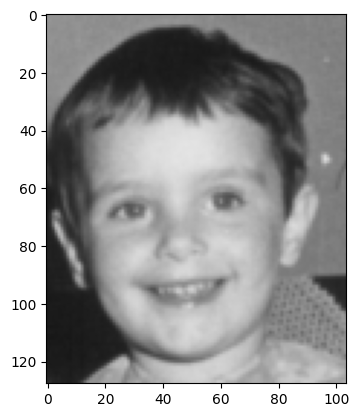

In [23]:
D_train = z_train
D_valid = z_val
D_test = z_test

img= X_train[0].reshape(128,104,3)
#Pour visualiser il faut le channel a la fin
plt.imshow(img , cmap='gray')
plt.show()


3. Générez un fichier *fg-net-nxm-split.csv* avec les données nettoyées et normalisées, où $n$ et $m$ représentent la résolution finale des images. En fait, vous devez prendre le fichier *fg-net-nxm.csv* et ajouter, l'usage de chaque image (similaire à FER2013)
   - Format du fichier: subject,age,pixels,use
      * sujet: integer
      * âge: integer
      * pixels: integer [0, 255]
      * use: nominal [training, validation, test]<br><br>

In [24]:
data = []
for i in range(len(X_train)):
    img = X_train[i]
 
    ch_ = img.flatten()
    # Flatten the image channels
    ch_str = ' '.join(map(str, ch_))

    # Combine id, age, and flattened pixel data
    row = [z_train[i], y_train[i] ,ch_str, "training"]
    data.append(row)

for i in range(len(X_val)):
    img = X_val[i]
 
    ch_ = img.flatten()
    # Flatten the image channels
    ch_str = ' '.join(map(str, ch_))

    # Combine id, age, and flattened pixel data
    row = [z_val[i], y_val[i] ,ch_str, "validation"]
    data.append(row)

for i in range(len(X_test)):
    img = X_test[i]
 
    ch_ = img.flatten()
    # Flatten the image channels
    ch_str = ' '.join(map(str, ch_))

    # Combine id, age, and flattened pixel data
    row = [z_test[i], y_test[i] ,ch_str, "test"]
    data.append(row)




# Create a DataFrame
columns = ['id', 'age', 'pixels', 'usage']
df = pd.DataFrame(data, columns=columns)

n = 128
m = 104
# Save to CSV
df.to_csv(f"content/fg-net-{n}x{m}-split.csv", index=False)

## 1b: Architecture CNN Régression FG-NET. (20%)
Point de départ: fichier *fg-net-nxm.csv* or *D_train*, *D_val*, *D_test*

1. Générer des partitions de données pour entraîner le CNN:
    - Ensemble d'entraînement: *X_train* et *y_train*
    - Ensemble de validation : *X_valid* et *y_val*
    - Ensemble de test       : *X_test* et  *y_test* <br><br>
    


In [25]:
print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape,     'z_train shape:', z_train.shape)
print('X_val shape:', X_val.shape,   'y_val shape:', y_val.shape, 'z_val shape:', z_val.shape)
print('X_test shape:', X_test.shape, 'y_test shape:', y_test.shape, 'z_test shape:', z_test.shape)


X_train shape: (509, 3, 128, 104) y_train shape: (509,) z_train shape: (509,)
X_val shape: (287, 3, 128, 104) y_val shape: (287,) z_val shape: (287,)
X_test shape: (204, 3, 128, 104) y_test shape: (204,) z_test shape: (204,)


2. Utiliser Pytorch ou [Tensorflow et Keras](https://www.tensorflow.org/tutorials/keras/regression) pour construire un réseau de neurones convolutifs pour extraire les primitives et faire la regression (end-to-end learning); Proposer une architecture appropriée pour FG-NET : nombre de couches convolutifs (CLs), nombre et dimension des filtres de chaque couche (kernel size), pas (stride), nombre et dimension des couches entièrement connectées (FC), fonctions d'activation de chaque couche, couches supplémentaires comme normalisation de batch, dropout, etc.

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


class AgeRegressorPyTorch(nn.Module):
    def __init__(self):
        super(AgeRegressorPyTorch, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # (3, 128, 104) -> (32, 128, 104)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # (32, 128, 104) -> (64, 128, 104)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # (64, 128, 104) -> (128, 128, 104)
        
        # Pooling and dropout layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions by half
        self.dropout = nn.Dropout2d(0.25)  # Dropout for convolutional layers
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 13, 512)  # Assuming input image size (128, 104) after pooling
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)  # Output layer for regression
        
        # Batch normalization
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #Conv->Relu->Pool
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        
        x = torch.flatten(x, 1)  # Flatten for fully connected layers
        
        x = F.relu(self.batch_norm1(self.fc1(x)))
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = self.fc3(x)  # No activation for the output layer as it's a regression task
        
        return x


In [38]:
from torch.utils.data import DataLoader

#Creating the dataset

# Load the data
train_data = DataLoader(TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float()), batch_size=32, shuffle=True)
val_data = DataLoader(TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float()), batch_size=32)
test_df = DataLoader(TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float()), batch_size=32)

test_loader = test_df
val_loader = val_data


3. Entraîner et optimiser les paramètres du réseau (modèle 1).


In [65]:
from sklearn.model_selection import ParameterGrid

# Define a grid of hyperparameters
param_grid = {
    'batch_size': [16],
    'learning_rate': [0.001, 0.01],
    'num_epochs': [25],
}
# Define the metrics
def calculate_mae(predictions, targets):
    return torch.mean(torch.abs(predictions - targets)).item()

def calculate_mse(predictions, targets):
    return torch.mean((predictions - targets) ** 2).item()


# Create a grid of all possible combinations
grid = ParameterGrid(param_grid)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

results =  []
# Iterate over all combinations
for params in grid:
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs']
    
    # Create DataLoader with current batch size
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float()), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float()), batch_size=batch_size)
    
    # Define and initialize model with current parameters
    model = AgeRegressorPyTorch()
    model.to(device)
    
    # Define optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Train the model
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate) #TODO: est-ce que c'est le bon optimizer?

            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_mae = 0.0
        val_mse = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)
            val_mae += calculate_mae(outputs, labels.unsqueeze(1)) * inputs.size(0)
            val_mse += calculate_mse(outputs, labels.unsqueeze(1)) * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_mae /= len(val_loader.dataset)
        val_mse /= len(val_loader.dataset)
    
    # Store results
    results.append({
        'params': params,
        'val_loss': val_loss,
        'val_mae': val_mae,
        'val_mse': val_mse
    })

    print(f"Params: {params} - Validation Loss: {val_loss:.4f}, MAE: {val_mae:.4f}, MSE: {val_mse:.4f}")

# Convert results to a DataFrame and save to CSV
import pandas as pd
df_results = pd.DataFrame(results)
df_results.to_csv('hyperparameter_results.csv', index=False)

print("Results saved to hyperparameter_results.csv")

KeyboardInterrupt: 

In [39]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error


def calculate_mae(predictions, labels):
    # Calculate Mean Absolute Error
    return mean_absolute_error(labels.cpu().numpy(), predictions.cpu().numpy())

# Assuming 'df_results' is a DataFrame with validation results
best_params = df_results.loc[df_results['val_loss'].idxmin()]['params']
print(f"Best Parameters: {best_params}")
print(f"Validation Loss: {df_results['val_loss'].min():.4f}")
print(f"Validation MAE: {df_results['val_mae'].min():.4f}")

# Define criterion (loss function)
criterion = nn.MSELoss()

#TODO verifier si on test le bon model

# Testing for the validation set
model.eval()
with torch.no_grad():
    val_loss = 0.0
    val_mae = 0.0
    for inputs, labels in val_loader:  # Assuming 'val_loader' is your DataLoader for validation
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        val_loss += loss.item() * inputs.size(0)
        val_mae += calculate_mae(outputs, labels.unsqueeze(1)) * inputs.size(0)
    
    val_mae /= len(val_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation MAE: {val_mae:.4f}")

# Testing for the test set
model.eval()
with torch.no_grad():
    test_loss = 0.0
    test_mae = 0.0
    for inputs, labels in test_df:  # Assuming 'test_loader' is your DataLoader for testing
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        test_loss += loss.item() * inputs.size(0)
        test_mae += calculate_mae(outputs, labels.unsqueeze(1)) * inputs.size(0)
    
    test_mae /= len(test_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")


Best Parameters: {'batch_size': 16, 'learning_rate': 0.001, 'num_epochs': 25}
Validation Loss: 167.1514
Validation MAE: 9.8403
Validation Loss: 196.1869
Validation MAE: 11.3456
Test Loss: 160.8836
Test MAE: 10.5110


5. Entraîner un autre modèle avec "data augmentation" pour améliorer la généralisation (modèle 2).



In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


#TODO Verifier si model est correct

class AgeRegressorPyTorch_DA(nn.Module):
    def __init__(self):
        super(AgeRegressorPyTorch_DA, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # (3, 128, 104) -> (32, 128, 104)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # (32, 128, 104) -> (64, 128, 104)
        
        # Pooling and dropout layers
        self.dropout = nn.Dropout2d(0.25)  # Dropout for convolutional layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions by half
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 32 * 26, 512)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)  # Output layer for regression
        
        # Batch normalization
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
  
        x = self.dropout(x)
        
        x = torch.flatten(x, 1)  # Flatten for fully connected layers
        
        x = F.relu(self.batch_norm1(self.fc1(x)))
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = self.fc3(x)  # No activation for the output layer as it's a regression task
        
        return x


In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert the tensor image to PIL Image for transformations
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=1),
    transforms.ColorJitter(brightness=0.02, contrast=0.02, saturation=0.02, hue=0.01),
    transforms.ToTensor(),  # Converts the PIL image back to a tensor
])

# Assuming X_train and y_train are numpy arrays
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create dataset and dataloader
dataset = CustomDataset(X_train_tensor, y_train_tensor, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example usage
for images, labels in dataloader:
    # Your training code here
    print(images.shape, labels.shape)
    break


torch.Size([32, 3, 128, 104]) torch.Size([32])


In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 25
learning_rate = 0.01
model2 = AgeRegressorPyTorch().to(device)

train_data = CustomDataset(X_train_tensor, y_train_tensor, transform=transform)
val_data = CustomDataset(X_val_tensor, y_val_tensor, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)



#TODO: Fix le training loop et utiliser le bon model (Avec DA)
# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        outputs = model2(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Validation loop
model2.eval()
with torch.no_grad():
    val_loss = 0.0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model2(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        
        val_loss += loss.item() * inputs.size(0)
    
    val_loss = val_loss / len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")

Epoch 1/25, Loss: 400.6585
Epoch 2/25, Loss: 399.6564
Epoch 3/25, Loss: 400.2549
Epoch 4/25, Loss: 400.5069
Epoch 5/25, Loss: 400.0957
Epoch 6/25, Loss: 400.2720
Epoch 7/25, Loss: 399.7510
Epoch 8/25, Loss: 400.2774
Epoch 9/25, Loss: 400.0958
Epoch 10/25, Loss: 400.8615
Epoch 11/25, Loss: 400.0254
Epoch 12/25, Loss: 400.3691
Epoch 13/25, Loss: 400.7248


KeyboardInterrupt: 

6. Faire une brève analyse des résultats et présenter vos considérations et conclusions sur les réseaux de neurones de convolution. Comparer avec les résultats obtenus avec les CNNs avec ceux obtenus dans les laboratoires précédents concernant des modèles de régression (TPs 5 et 6).



| Algorithme            | Paramètres    |  MSE  |  MAE  | ????? |
|-----------------------|---------------|-------|-------|-------|
| Regr lineaire         |               |94.96  | 4.47  |  4.61%   |
| Regr Ridge            | alpha = 0.7   |94.91  | 7.46  |  4.72%   |
| KNN                   | k = 4         |235.93 | 10.46 |  8.24%   |
| MLP 1                 | 1024:512:1 |8.752 |9.59 | 29.93 %      |
| MLP 2                 | 512:128:1      |8.337. |126.47 |    31.48%   |
| CNN 1                 | 512:100:100:1 |XXX.XX |XXX.XX |       |
| CNN 2 (DA)            | 512:50:1      |XXX.XX |XXX.XX |       |

## 1c: Fine-tuning d'un CNN pré-entraîné pour FG-NET. (10%)

1. Récupérer une architecture CNN pré-entraînée disponible dans Pytorch ou Keras pour faire un “transfert de connaissance (transfer learning). Faire un "fine-tuning" du modèle choisi sur FG-NET puis expliquer les modifications/adaptations apportées au modèle pré-entraîné (p. ex., description de couches ajoutées ou enlevées pour faire fonctionner le modèle sur vos données)



In [ ]:
#TODO Implemeter cela

2. Faire une brève analyse des résultats et présenter vos considérations et conclusions sur les réseaux de neurones de convolution. Comparer avec les résultats obtenus avec les CNNs avec ceux obtenus dans les laboratoires précédents concernant des modèles de régression (TPs 5 et 6).

| Algorithme            | Paramètres    |  MSE  |  MAE  | ????? |
|-----------------------|---------------|-------|-------|-------|
| Regr lineaire         |               |94.96  | 4.47  |  4.61%   |
| Regr Ridge            | alpha = 0.7   |94.91  | 7.46  |  4.72%   |
| KNN                   | k = 4         |235.93 | 10.46 |  8.24%   |
| MLP 1                 | 1024:512:1 |8.752 |9.59 | 29.93 %      |
| MLP 2                 | 512:128:1      |8.337. |126.47 |    31.48%   |
| CNN 1                 | 512:100:100:1 |XXX.XX |XXX.XX |       |
| CNN 2 (DA)            | 512:50:1      |XXX.XX |XXX.XX |       |
| CNN 1                 | 512:100:100:1 |XXX.XX |XXX.XX |       |
| CNN 2 (DA)            | 512:50:1      |XXX.XX |XXX.XX |       |
| VGG16 (DA)            | 512:50:1      |XXX.XX |XXX.XX |       |

Votre description ici

# Partie 2 - Apprentissage de représentation et classification avec FER (30%)

Point de départ: fichier *fer2013-clean-pre.csv* - images nettoyées et normalisées.

## 2: Architecture CNN Classification FER2013 (30%)


###  <font color=blue> À faire: </font>
1. Reprenez votre ensemble de données nettoyé et repérez les trois partitions de données: apprentissage, validation et test.

In [ ]:
# Load data
ferData = np.loadtxt( 'fer2013-clean-pre.csv', delimiter=',', dtype=str )

# Images d'entraînement
Xtrain = <à compléter>
ytrain = <à compléter>

# Images de validation
Xval = <à compléter>
yval = <à compléter>

# Images de test
Xtest = <à compléter>
ytest = <à compléter>

print(Xtrain.shape, Xval.shape, Xtest.shape)

SyntaxError: invalid syntax (2155295739.py, line 5)

2. Utiliser Pytorch ou [Tensorflow et Keras](https://www.tensorflow.org/tutorials/keras/classification) pour construire un réseau de neurones convolutif (classe) qui vous servira par la suite à apprendre une représentation des images de visage (primitives) et faire la classification (end-to-end learning). Vous pouvez reprendre l'architecture de la partie 1 avec quelques adaptations pour qu'il fonctionne sur ce problème.


2. Entraîner et optimiser les paramètres du réseau (modèle 1).


3. Entraîner un autre modèle avec "data augmentation" pour améliorer la généralisation (modèle 2).


4. Prenez le modèle le plus performant pour faire la prédiction sur tous les exemples (apprentissage, validation, test) et rapporter les résultats (comme fait dans les TP1 à TP4 et TP6):<br>
   3a. Rapport de classification produit avec *<font color=green>from sklearn.metrics import classification_report</font>*<br>
   3b. taux de classification correct sur les trois (3) ensembles de données (sous la forme d'un tableau)<br>
   3c. matrice de confusion produite avec *<font color=green> from sklearn.metrics import confusion_matrix</font>* pour les résultats sur l'ensemble de tests (matrice 7 $\times$ 7 - étiquettes $\times$ prédictions)



5. Comparez les résultats avec ceux attendus avec le réseau MLP (TP6), les primitives « deep » réduits (TP4), les primitives « deep » (TP3), les primitives globales/locales (TP2) et *template matching* (TP1)



6. Faire une brève analyse des résultats et présenter vos considérations et conclusions sur la pertinence / advantages / désavantages des réseaux neuronaux.